In [12]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
import os
sys.path.append(os.path.abspath('..'))
from data.preprocessing import Preprocessor
from figures.plots import show_embeddings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных

embed_df = pd.read_csv('../data/final_data/embed_df.csv')
embed_df['date'] = pd.to_datetime(embed_df['date'], format='%Y-%m-%d')

spec = pd.read_csv('../data/processed_data/specs.csv')
spec['spec_date'] = pd.to_datetime(spec['spec_date'], format='%Y-%m-%d')
spec['delivery_period_end'] = pd.to_datetime(spec['delivery_period_end'], format='%Y-%m-%d')

In [3]:
embed_df.head(2)

,spec_id,supplier,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Рязанова А.В. ИП Глава К(Ф)Х_ЮР Валуйский МЭЗ ...,Рязанова А.В. ИП Глава К(Ф)Х,2022-07-06,0.012422,-0.152277,-0.371495,0.345143,0.234435,-0.347446,0.003021,-0.117278,0.156940,-0.267533,0.166429,0.015203,-0.192737,0.055639,-0.065744,0.213519
1,"Осипов Л.А. ИП Глава К(Ф)Х_Юг Руси, АО_2022-07-12",Осипов Л.А. ИП Глава К(Ф)Х,2022-07-20,0.306000,-0.582370,-0.616625,0.449130,0.555506,-0.703764,-0.839743,-0.395974,0.175395,-0.431890,0.684241,-0.742406,-0.344925,-0.425448,-0.146025,0.416976


In [4]:
spec.head(2)

,supplier,supplier_status,item,basis,spec_date,delivery_period_end,payment_terms,option,logistics,declared_price,consent_price,spec_price,volume_requested,volume_contracted,bids_submitted,bids_contracted,id,late
0,50 ЛЕТ ОКТЯБРЯ ООО,СХТП,подсолнечник,"Юг Руси, АО",2022-12-19,2022-12-25,По факту,15.0,0.0,25.5,25.0,25.0,40.0,60.0,1.0,1.0,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2022-12-19",0
1,50 ЛЕТ ОКТЯБРЯ ООО,СХТП,подсолнечник,"Юг Руси, АО",2023-01-24,2023-02-12,По факту,15.0,0.0,27.5,27.5,27.5,50.0,59.0,1.0,1.0,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2023-01-24",0


In [5]:
"""
Создание эмбеддинга поставщика для спецификации:
Эмбеддинг получается путём усреднения эмбеддингов по поставкам,
которые закончились до начала рассматриваемой спецификации.
"""

spec_colums = ['id', 'supplier', 'spec_date', 'bids_contracted', 'late']
data = pd.DataFrame(columns = list(embed_df.columns[3:]) + spec_colums)

for i in tqdm(range(len(spec))):
    supplier = spec.loc[i]['supplier']
    date = spec.loc[i]['spec_date']
    
    embed = embed_df.loc[(embed_df['supplier'] == supplier) & (embed_df['date'] < date)] \
        [embed_df.columns[3:]].mean().values
    
    spec_info = spec.loc[i][spec_colums].values
    
    data.loc[len(data)] = np.concatenate((embed, spec_info))

100%|█████████████████████████████████████████████████████████████████████████████| 6519/6519 [00:26<00:00, 250.72it/s]


In [6]:
"""
Анализ пропущенных значений
"""

unknown_total = data['0'].isna().sum()
unknown_supplier = len(spec[~spec['supplier'].isin(embed_df['supplier'])])
supplier_first_spec = spec['supplier'].map(lambda x: embed_df.loc[embed_df['supplier'] == x]['date'].min())
unknown_fist_spec = len(spec[spec['spec_date'] <= supplier_first_spec])

print(f'У {unknown_supplier/unknown_total*100}% поставщик не предсавлен в embed_d\n'
      + f'У {unknown_fist_spec/unknown_total*100}% поставщика ещё не было поставок')

data = data.dropna()

У 34.0% поставщик не предсавлен в embed_d
У 66.0% поставщика ещё не было поставок


In [7]:
"""
Разделение набора данных
"""

X_train, X_test, spec_train, spec_test = train_test_split(
    data.drop(spec_colums, 1), data[spec_colums],
    test_size=0.33, random_state=42
)

# законтрактованность
y_train = spec_train['bids_contracted'].astype('int')
y_test = spec_test['bids_contracted'].astype('int')

# опоздал/не опоздал
late_train = spec_train['late'].astype('int')
late_test = spec_test['late'].astype('int')

In [8]:
"""
Предсказание законтрактованности
"""

def estimate(model, X_test, y_test):
    accuracy = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Accuracy: {accuracy}\nROC AUC: {roc_auc}')

print('Логистическая регрессия:')
model = LogisticRegression().fit(X_train, y_train)
estimate(model, X_test, y_test)
print('\n')

print('Бустинг:')
model = CatBoostClassifier(verbose = 0).fit(X_train, y_train)
estimate(model, X_test, y_test)

Логистическая регрессия:
Accuracy: 0.6820809248554913
ROC AUC: 0.6937069770408902


Бустинг:
Accuracy: 0.7241948802642444
ROC AUC: 0.7455288018232745


In [9]:
"""
Оцениваем ранжирование по каждому дню отдельно
"""

actual = []
predicted = []
days_indexes = spec_test.groupby('spec_date').apply(lambda x: x.index)

for day in days_indexes:
    actual.append(y_test.loc[day].values)
    predicted.append(model.predict_proba(X_test.loc[day])[:, 1])

def map_(actual, predicted):
    return np.mean([average_precision_score(a,p) for a,p in zip(actual, predicted)])

print(f'Mean average precision: {map_(actual, predicted)}')

Mean average precision: 0.7576777935552031


In [10]:
"""
Предсказание опаздывания
"""

late_model = CatBoostClassifier(class_weights=[0.1, 0.1], verbose = 0).fit(X_train, late_train)
estimate(late_model, X_test, late_test)

Accuracy: 0.9504541701073493
ROC AUC: 0.5477687626774848


Text(33.22222222222222, 0.5, 'Truth')

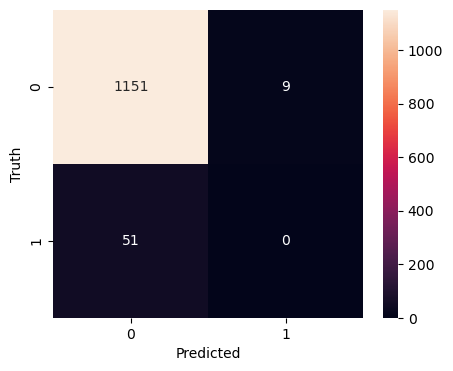

In [11]:
"""
Матрица предсказаний опаздывания 
"""

cm = confusion_matrix(late_test, late_model.predict(X_test))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

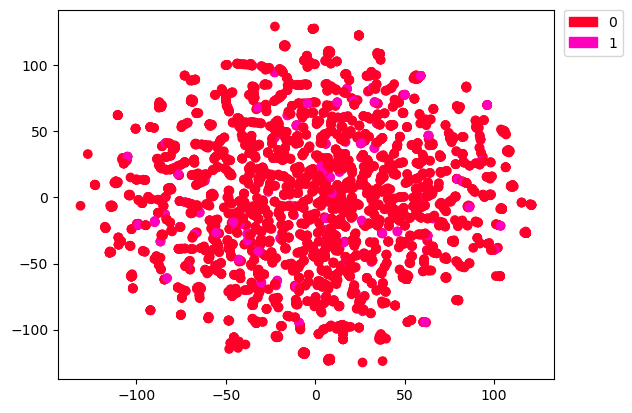

In [21]:
show_embeddings(data.values[:, :16], data['late'])